In [1]:
# Imports
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K

from tqdm import tqdm
from tqdm.keras import TqdmCallback

sns.set_style("dark")
warnings.filterwarnings("ignore")
plt.rcParams['axes.grid'] = True

2024-01-04 23:54:37.880364: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-04 23:54:38.071961: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-04 23:54:38.071996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-04 23:54:38.102634: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-04 23:54:38.169528: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-04 23:54:38.170966: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# Constants

CMAP = "YlGnBu"
TARGET = "income"
BATCH_SIZE = 32
FILES = "files/"

### Read data:

In [3]:
# params

train_df = pd.read_csv(FILES + "train.csv")
val_df = pd.read_csv(FILES + "val.csv")
test_df = pd.read_csv(FILES + "test.csv")

X_train, y_train = train_df.drop(columns=[TARGET]), train_df[TARGET]
X_val, y_val = val_df.drop(columns=[TARGET]), val_df[TARGET]
X_test, y_test = test_df.drop(columns=[TARGET]), test_df[TARGET]

n_features = X_train.shape[1]

y_train = y_train.astype(np.int32).values
X_train = tf.convert_to_tensor(X_train)

y_val = y_val.astype(np.int32).values
X_val = tf.convert_to_tensor(X_val)

y_test = y_test.astype(np.int32).values
X_test = tf.convert_to_tensor(X_test)

### SD:

In [4]:
initializer = tf.keras.initializers.GlorotNormal(seed=None)

In [5]:
def get_GD_model(learning_rate, epochs):
    model = Sequential()
    model.add(Dense(10, 
                    input_shape=(n_features,), 
                    activation='tanh', 
                    kernel_initializer=initializer))
    model.add(Dense(10, 
                    activation='tanh',
                    kernel_initializer=initializer))
    model.add(Dense(10, 
                    activation='tanh',
                    kernel_initializer=initializer))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', 
                  optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate), 
                  metrics=['accuracy'])
    callbacks = \
    model.fit(X_train, 
              y_train, 
              epochs = epochs, 
              batch_size = X_train.shape[0],
              validation_data=(X_val, y_val),
              verbose=0,)
    
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    train_pred_y = model.predict(X_train)
    test_pred_y = model.predict(X_test)
    
    return callbacks, bce(y_train, train_pred_y), bce(y_test, test_pred_y)

In [6]:
# №1
callbacks1, train_loss1, test_loss1 = get_GD_model(learning_rate=0.01, epochs=100)
# №2
callbacks2, train_loss2, test_loss2 = get_GD_model(learning_rate=0.01, epochs=200)
# №3
callbacks3, train_loss3, test_loss3 = get_GD_model(learning_rate=0.005, epochs=100)
# №4
callbacks4, train_loss4, test_loss4 = get_GD_model(learning_rate=0.005, epochs=200)

138/138 [==============================] - 0s 785us/step


2024-01-04 23:54:43.517457: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2801373184 exceeds 10% of free system memory.
2024-01-04 23:54:43.785132: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2801373184 exceeds 10% of free system memory.
2024-01-04 23:54:44.117801: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2801373184 exceeds 10% of free system memory.
2024-01-04 23:54:56.815957: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2801373184 exceeds 10% of free system memory.


138/138 [==============================] - 0s 959us/step


2024-01-04 23:55:07.827864: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2801373184 exceeds 10% of free system memory.


138/138 [==============================] - 0s 995us/step


In [7]:
print(f"Train loss: {train_loss1}, test loss: {test_loss1} --- 0.01 lr 100 epochs")
print(f"Train loss: {train_loss2}, test loss: {test_loss2} --- 0.01 lr 200 epochs")
print(f"Train loss: {train_loss3}, test loss: {test_loss3} --- 0.005 lr 100 epochs")
print(f"Train loss: {train_loss4}, test loss: {test_loss4} --- 0.005 lr 200 epochs")

Train loss: 0.5928162932395935, test loss: 0.5935233235359192 --- 0.01 lr 100 epochs
Train loss: 0.5619239211082458, test loss: 0.5629846453666687 --- 0.01 lr 200 epochs
Train loss: 0.6152721047401428, test loss: 0.6143566370010376 --- 0.005 lr 100 epochs
Train loss: 0.5792156457901001, test loss: 0.5809824466705322 --- 0.005 lr 200 epochs


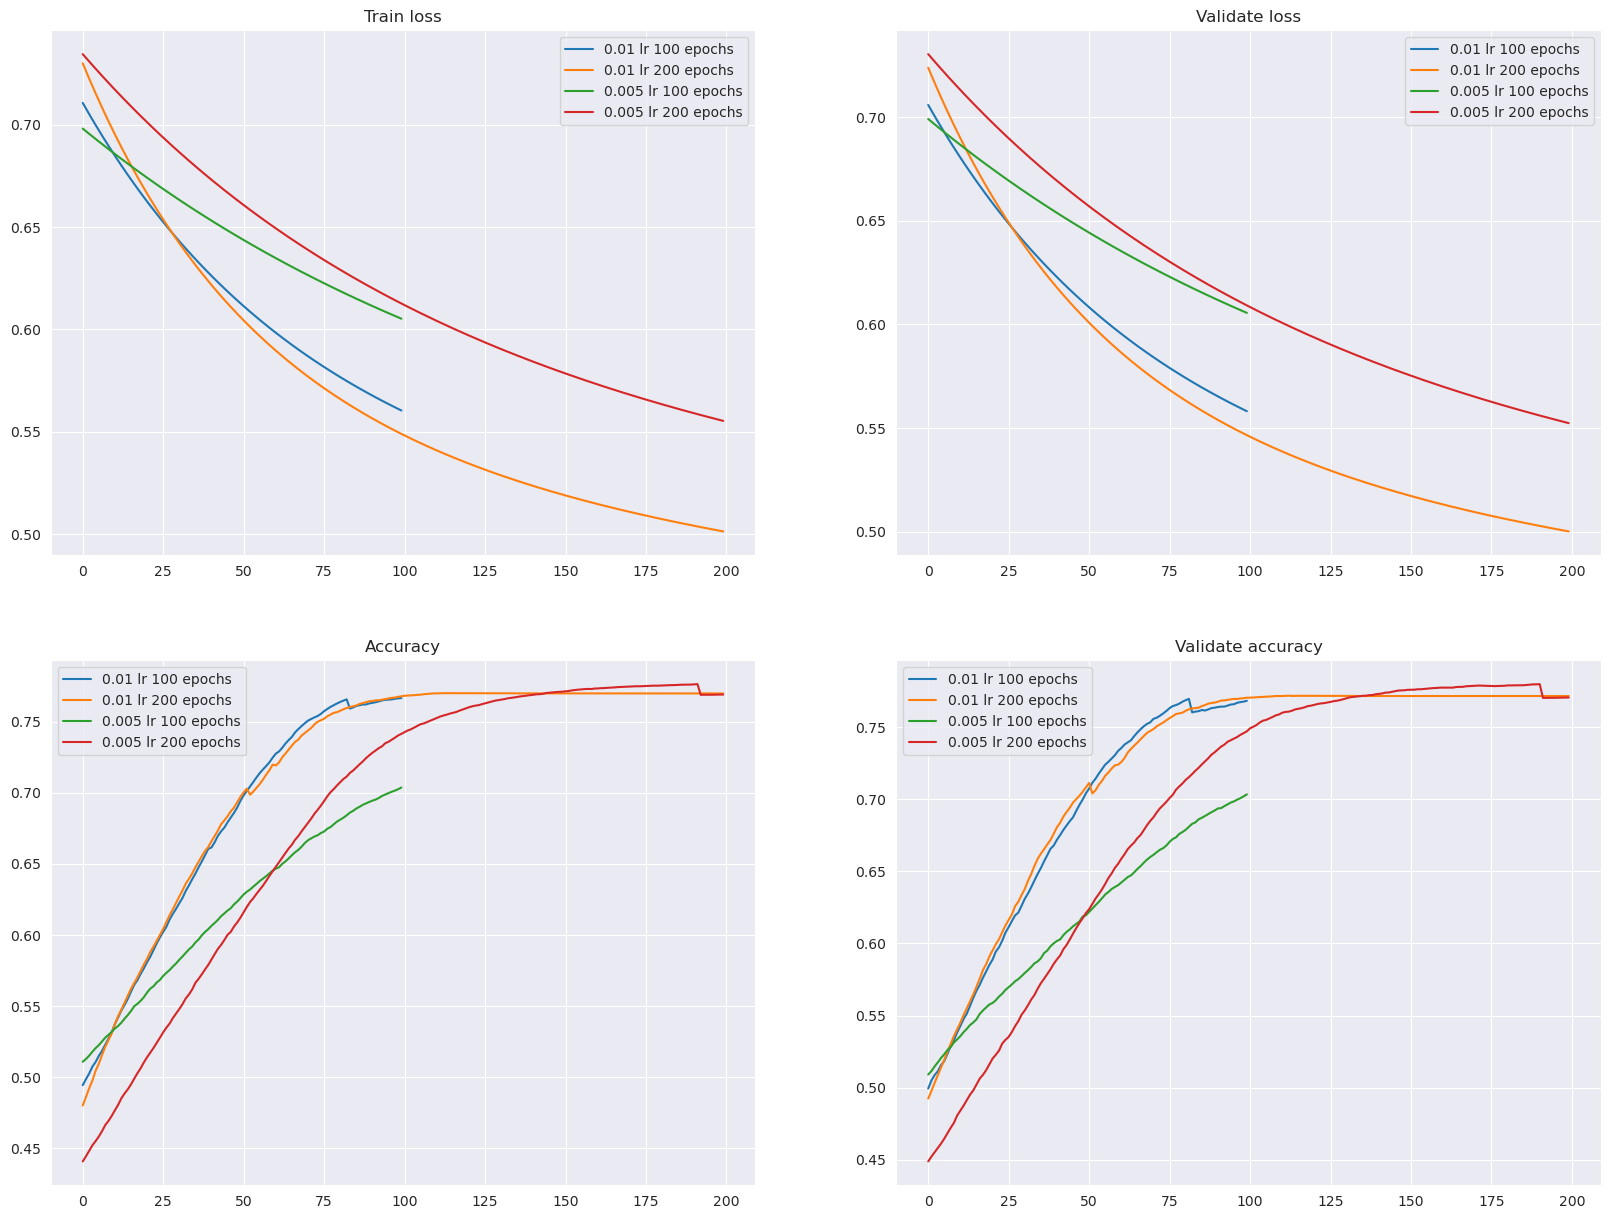

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

sns.lineplot(data=callbacks1.history['loss'], label="0.01 lr 100 epochs",
             ax=ax1)
sns.lineplot(data=callbacks2.history['loss'], label="0.01 lr 200 epochs",
             ax=ax1)
sns.lineplot(data=callbacks3.history['loss'], label="0.005 lr 100 epochs",
             ax=ax1)
sns.lineplot(data=callbacks4.history['loss'], label="0.005 lr 200 epochs",
             ax=ax1)
ax1.set_title("Train loss")


sns.lineplot(data=callbacks1.history['val_loss'], label="0.01 lr 100 epochs",
             ax=ax2)
sns.lineplot(data=callbacks2.history['val_loss'], label="0.01 lr 200 epochs",
             ax=ax2)
sns.lineplot(data=callbacks3.history['val_loss'], label="0.005 lr 100 epochs",
             ax=ax2)
sns.lineplot(data=callbacks4.history['val_loss'], label="0.005 lr 200 epochs",
             ax=ax2)
ax2.set_title("Validate loss")


sns.lineplot(data=callbacks1.history['accuracy'], label="0.01 lr 100 epochs",
             ax=ax3)
sns.lineplot(data=callbacks2.history['accuracy'], label="0.01 lr 200 epochs",
             ax=ax3)
sns.lineplot(data=callbacks3.history['accuracy'], label="0.005 lr 100 epochs",
             ax=ax3)
sns.lineplot(data=callbacks4.history['accuracy'], label="0.005 lr 200 epochs",
             ax=ax3)
ax3.set_title("Accuracy")


sns.lineplot(data=callbacks1.history['val_accuracy'], label="0.01 lr 100 epochs",
             ax=ax4)
sns.lineplot(data=callbacks2.history['val_accuracy'], label="0.01 lr 200 epochs",
             ax=ax4)
sns.lineplot(data=callbacks3.history['val_accuracy'], label="0.005 lr 100 epochs",
             ax=ax4)
sns.lineplot(data=callbacks4.history['val_accuracy'], label="0.005 lr 200 epochs",
             ax=ax4)
ax4.set_title("Validate accuracy")


plt.show()

### GDM & NAG:

In [9]:
initializer = tf.keras.initializers.GlorotNormal(seed=None)
lr = 0.01

In [10]:
def get_GDM_or_NAG_model(epochs, momentum, nesterov=False):
    model = Sequential()
    model.add(Dense(10, 
                    input_shape=(n_features,), 
                    activation='tanh', 
                    kernel_initializer=initializer))
    model.add(Dense(10, 
                    activation='tanh',
                    kernel_initializer=initializer))
    model.add(Dense(10, 
                    activation='tanh',
                    kernel_initializer=initializer))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', 
                  optimizer=tf.keras.optimizers.SGD(learning_rate=lr,
                                                    momentum=momentum,
                                                    nesterov=nesterov), 
                  metrics=['accuracy'])
    callbacks = \
    model.fit(X_train, 
              y_train, 
              epochs = epochs, 
              batch_size = X_train.shape[0],
              validation_data=(X_val, y_val),
              verbose=0,)
    
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    train_pred_y = model.predict(X_train)
    test_pred_y = model.predict(X_test)
    
    return callbacks, bce(y_train, train_pred_y), bce(y_test, test_pred_y)

In [11]:
momentums = [0, 0, 0.5, 0.5, 0.8, 0.8, 1, 1]
epochs = [100, 200, 100, 200, 100, 200, 100, 200]

nesterovs = [True, False, True, False, True, False, True, False]

callbacks = []
train_losses = []
test_losses = []

for m, e, n in zip(momentums, epochs, nesterovs):
    calls, train_loss, test_loss = \
        get_GDM_or_NAG_model(epochs=e, momentum=m, nesterov=n)
    callbacks.append(calls)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

138/138 [==============================] - 0s 983us/step


Text(0.5, 1.0, 'Validation accuracy')

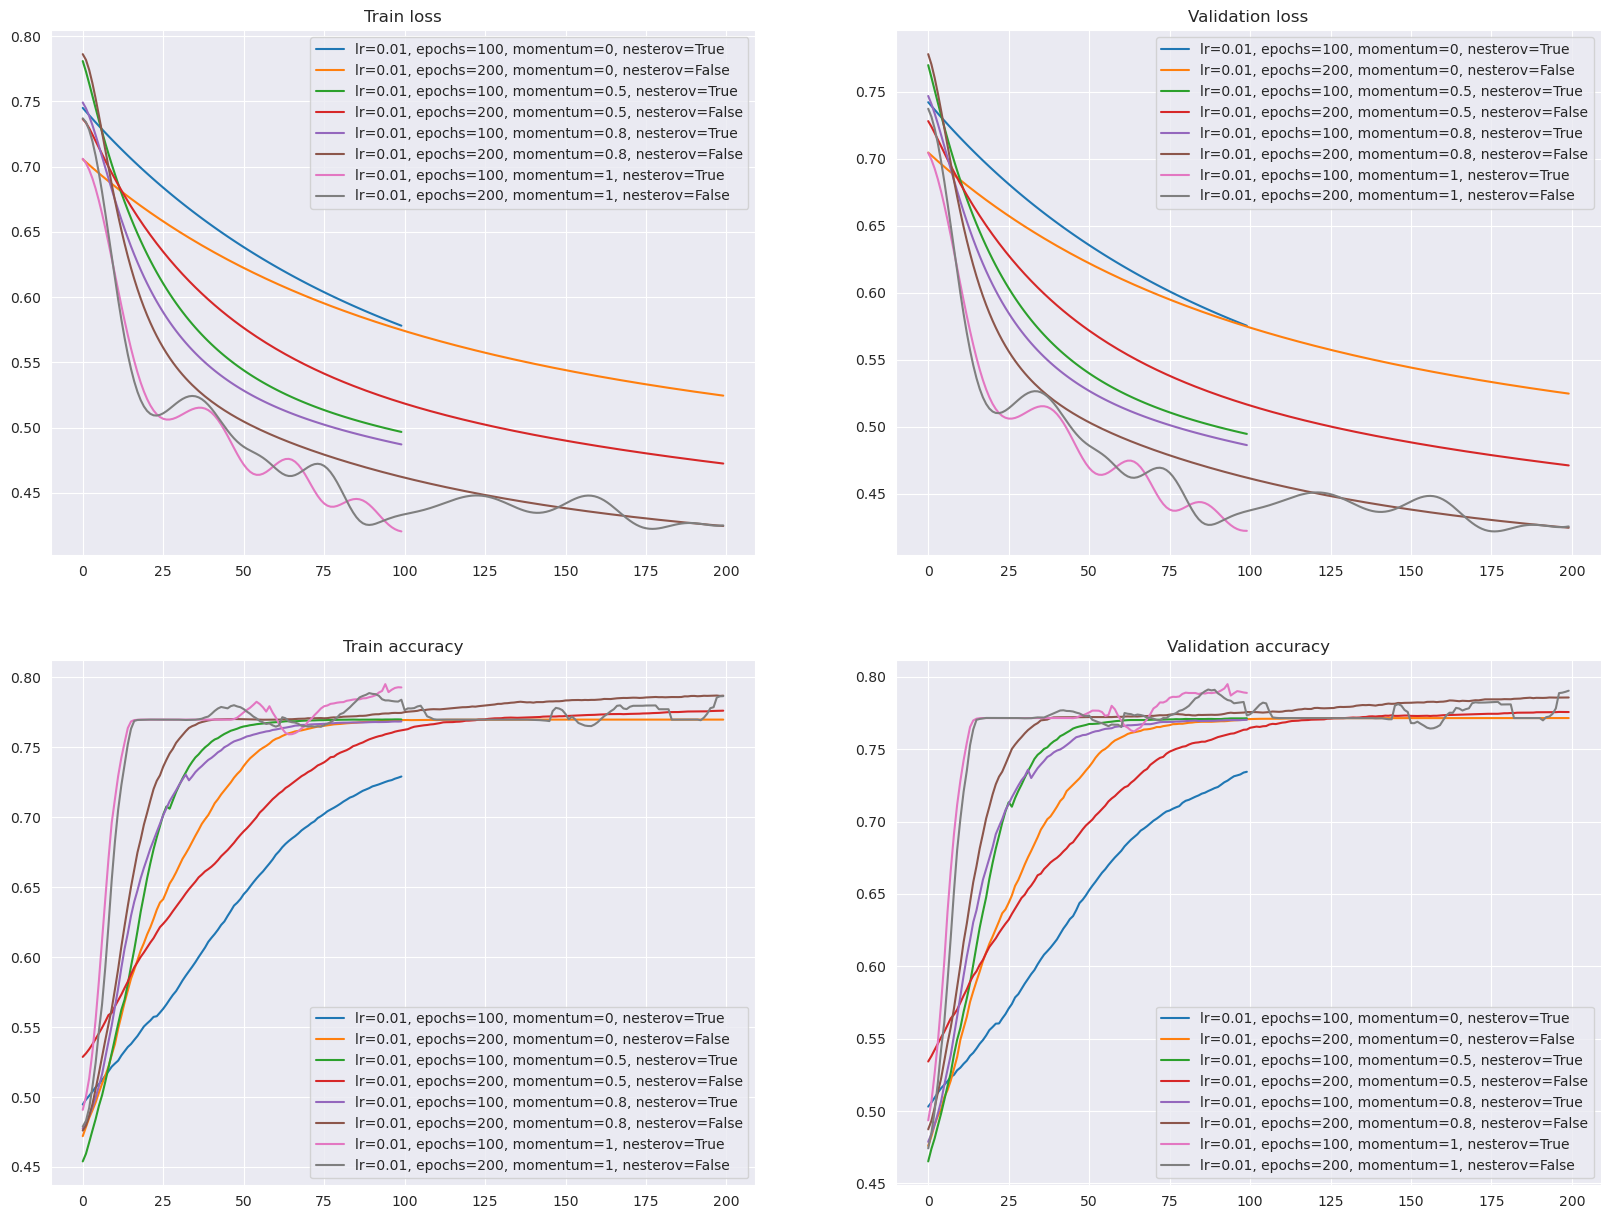

In [12]:
fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

for callback, train_loss, test_loss, momentum, epoch, nesterov \
in zip(callbacks, train_losses, test_losses, momentums, epochs, nesterovs):
    sns.lineplot(data=callback.history['loss'], 
                 label=f"lr=0.01, epochs={epoch}, momentum={momentum}, nesterov={nesterov}",
             ax=ax1)
ax1.set_title("Train loss")


for callback, train_loss, test_loss, momentum, epoch, nesterov \
in zip(callbacks, train_losses, test_losses, momentums, epochs, nesterovs):
    sns.lineplot(data=callback.history['val_loss'], 
                 label=f"lr=0.01, epochs={epoch}, momentum={momentum}, nesterov={nesterov}",
             ax=ax2)
ax2.set_title("Validation loss")


for callback, train_loss, test_loss, momentum, epoch, nesterov \
in zip(callbacks, train_losses, test_losses, momentums, epochs, nesterovs):
    sns.lineplot(data=callback.history['accuracy'], 
                 label=f"lr=0.01, epochs={epoch}, momentum={momentum}, nesterov={nesterov}",
             ax=ax3)
ax3.set_title("Train accuracy")


for callback, train_loss, test_loss, momentum, epoch, nesterov \
in zip(callbacks, train_losses, test_losses, momentums, epochs, nesterovs):
    sns.lineplot(data=callback.history['val_accuracy'], 
                 label=f"lr=0.01, epochs={epoch}, momentum={momentum}, nesterov={nesterov}",
             ax=ax4)
ax4.set_title("Validation accuracy")


### AdaGrad:

In [13]:
initializer = tf.keras.initializers.GlorotNormal(seed=None)
lr = 0.01

In [14]:
def get_AdaGrad_model(learning_rate, epochs):
    
    model = Sequential()
    model.add(Dense(10, 
                    input_shape=(n_features,), 
                    activation='tanh', 
                    kernel_initializer=initializer))
    model.add(Dense(10, 
                    activation='tanh',
                    kernel_initializer=initializer))
    model.add(Dense(10, 
                    activation='tanh',
                    kernel_initializer=initializer))
    model.add(Dense(1, activation='sigmoid'))
    
    def get_lr_metric(optimizer):
        def lr(y_true, y_pred):
            return tf.divide(learning_rate, tf.sqrt(optimizer._accumulators[-1]))
        return lr

    optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
    lr_metric = get_lr_metric(optimizer)

    model.compile(
        optimizer=optimizer,
        metrics=['accuracy', lr_metric],
        loss='mean_absolute_error', 
        )
    layer1_weight0 = []
    layer2_weight0 = []
    layer3_weight0 = []
    
    layer1_weight0_calls = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda batch, logs: layer1_weight0.append(model.layers[0].get_weights()[0][0][0]))
    layer2_weight0_calls = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda batch, logs: layer2_weight0.append(model.layers[1].get_weights()[0][0][0]))
    layer3_weight0_calls = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda batch, logs: layer3_weight0.append(model.layers[2].get_weights()[0][0][0]))

    callbacks = \
    model.fit(X_train, 
              y_train, 
              epochs = epochs, 
              batch_size = X_train.shape[0],
              validation_data=(X_val, y_val),
              verbose=0,
              callbacks=[layer1_weight0_calls, layer2_weight0_calls, layer3_weight0_calls])
    
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    train_pred_y = model.predict(X_train)
    test_pred_y = model.predict(X_test)
    
    callbacks.history['layer1_weight0'] = layer1_weight0
    callbacks.history['layer2_weight0'] = layer2_weight0
    callbacks.history['layer3_weight0'] = layer3_weight0
    
    return callbacks, bce(y_train, train_pred_y), bce(y_test, test_pred_y)

In [15]:
callback, train_loss, test_loss = get_AdaGrad_model(learning_rate=lr, epochs=200)

138/138 [==============================] - 0s 960us/step


Text(0.5, 1.0, 'Layer3 weight (0,0)')

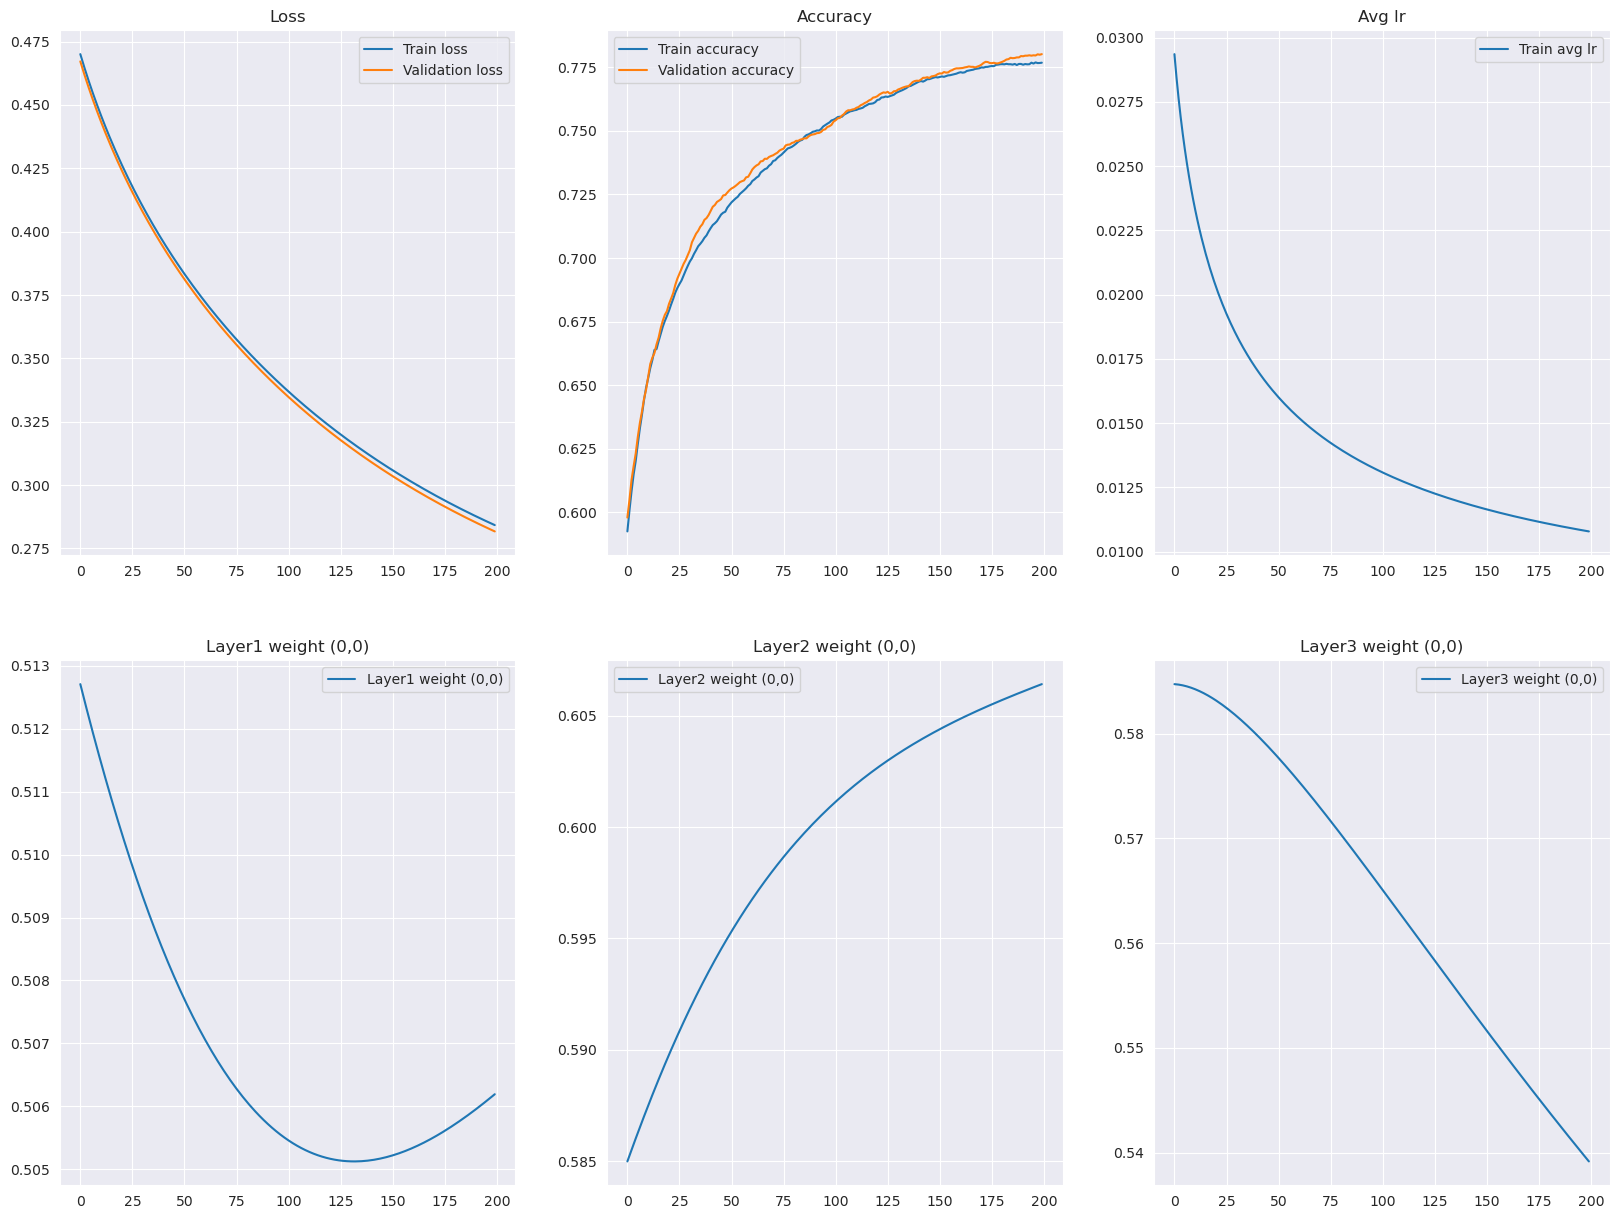

In [16]:
fig,((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 15))

sns.lineplot(data=callback.history['loss'], 
                 label="Train loss",
             ax=ax1)
sns.lineplot(data=callback.history['val_loss'], 
                 label="Validation loss",
             ax=ax1)
ax1.set_title("Loss")


sns.lineplot(data=callback.history['accuracy'], 
                 label="Train accuracy",
             ax=ax2)
sns.lineplot(data=callback.history['val_accuracy'], 
                 label="Validation accuracy",
             ax=ax2)
ax2.set_title("Accuracy")


sns.lineplot(data=np.cumsum(callback.history['lr']) / np.arange(1, len(callback.history['lr'])+1), 
                 label="Train avg lr",
             ax=ax3)
ax3.set_title("Avg lr")


sns.lineplot(data=callback.history['layer1_weight0'], 
                 label="Layer1 weight (0,0)",
             ax=ax4)
ax4.set_title("Layer1 weight (0,0)")


sns.lineplot(data=callback.history['layer2_weight0'], 
                 label="Layer2 weight (0,0)",
             ax=ax5)
ax5.set_title("Layer2 weight (0,0)")


sns.lineplot(data=callback.history['layer3_weight0'], 
                 label="Layer3 weight (0,0)",
             ax=ax6)
ax6.set_title("Layer3 weight (0,0)")


In [17]:
print(f"Train loss: {train_loss}, test loss: {test_loss}")

Train loss: 0.7066975235939026, test loss: 0.7165012955665588


### RMSProp & AdaDelta:

In [18]:
initializer = tf.keras.initializers.GlorotNormal(seed=None)
lr = 0.01

In [19]:
def get_RMSProp_model(learning_rate, rho, epochs):
    
    model = Sequential()
    model.add(Dense(10, 
                    input_shape=(n_features,), 
                    activation='tanh', 
                    kernel_initializer=initializer))
    model.add(Dense(10, 
                    activation='tanh',
                    kernel_initializer=initializer))
    model.add(Dense(10, 
                    activation='tanh',
                    kernel_initializer=initializer))
    model.add(Dense(1, activation='sigmoid'))
    
    def get_lr_metric(optimizer):
        def lr(y_true, y_pred):
            return tf.divide(learning_rate, tf.sqrt(optimizer._average_gradients[-1]))
        return lr

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, rho=rho, centered=True)
    lr_metric = get_lr_metric(optimizer)

    model.compile(
        optimizer=optimizer,
        metrics=['accuracy', lr_metric],
        loss='mean_absolute_error', 
        )
    layer1_weight0 = []
    layer2_weight0 = []
    layer3_weight0 = []
    
    layer1_weight0_calls = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda batch, logs: layer1_weight0.append(model.layers[0].get_weights()[0][0][0]))
    layer2_weight0_calls = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda batch, logs: layer2_weight0.append(model.layers[1].get_weights()[0][0][0]))
    layer3_weight0_calls = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda batch, logs: layer3_weight0.append(model.layers[2].get_weights()[0][0][0]))

    callbacks = \
    model.fit(X_train, 
              y_train, 
              epochs = epochs, 
              batch_size = X_train.shape[0],
              validation_data=(X_val, y_val),
              verbose=0,
              callbacks=[layer1_weight0_calls, layer2_weight0_calls, layer3_weight0_calls])
    
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    train_pred_y = model.predict(X_train)
    test_pred_y = model.predict(X_test)
    
    callbacks.history['layer1_weight0'] = layer1_weight0
    callbacks.history['layer2_weight0'] = layer2_weight0
    callbacks.history['layer3_weight0'] = layer3_weight0
    
    return callbacks, bce(y_train, train_pred_y), bce(y_test, test_pred_y)

In [20]:
def get_Adadelta_model(learning_rate, rho, epochs):
    
    model = Sequential()
    model.add(Dense(10, 
                    input_shape=(n_features,), 
                    activation='tanh', 
                    kernel_initializer=initializer))
    model.add(Dense(10, 
                    activation='tanh',
                    kernel_initializer=initializer))
    model.add(Dense(10, 
                    activation='tanh',
                    kernel_initializer=initializer))
    model.add(Dense(1, activation='sigmoid'))
    
    def get_lr_metric(optimizer):
        def lr(y_true, y_pred):
            return tf.divide(tf.sqrt(optimizer._accumulated_delta_vars[-1]), tf.sqrt(optimizer._accumulated_grads[-1]))
        return lr

    optimizer = tf.keras.optimizers.Adadelta(learning_rate=learning_rate, rho=rho)
    lr_metric = get_lr_metric(optimizer)

    model.compile(
        optimizer=optimizer,
        metrics=['accuracy', lr_metric],
        loss='mean_absolute_error', 
        )
    layer1_weight0 = []
    layer2_weight0 = []
    layer3_weight0 = []
    
    layer1_weight0_calls = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda batch, logs: layer1_weight0.append(model.layers[0].get_weights()[0][0][0]))
    layer2_weight0_calls = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda batch, logs: layer2_weight0.append(model.layers[1].get_weights()[0][0][0]))
    layer3_weight0_calls = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda batch, logs: layer3_weight0.append(model.layers[2].get_weights()[0][0][0]))

    callbacks = \
    model.fit(X_train, 
              y_train, 
              epochs = epochs, 
              batch_size = X_train.shape[0],
              validation_data=(X_val, y_val),
              verbose=0,
              callbacks=[layer1_weight0_calls, layer2_weight0_calls, layer3_weight0_calls])
    
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    train_pred_y = model.predict(X_train)
    test_pred_y = model.predict(X_test)
    
    callbacks.history['layer1_weight0'] = layer1_weight0
    callbacks.history['layer2_weight0'] = layer2_weight0
    callbacks.history['layer3_weight0'] = layer3_weight0
    
    return callbacks, bce(y_train, train_pred_y), bce(y_test, test_pred_y)

In [21]:
rms_callbacks = []
rms_train_loss = [] 
rms_test_loss = [] 

delta_callbacks = []
delta_train_loss = [] 
delta_test_loss = [] 

for rho in [0, 0.5, 0.95, 0.99]:
    call, train, test = get_RMSProp_model(learning_rate=lr, rho=rho, epochs=200)
    rms_callbacks.append(call)
    rms_train_loss.append(train)
    rms_test_loss.append(test)
    call, train, test = get_Adadelta_model(learning_rate=lr, rho=rho, epochs=200)
    delta_callbacks.append(call)
    delta_train_loss.append(train)
    delta_test_loss.append(test)

138/138 [==============================] - 0s 956us/step


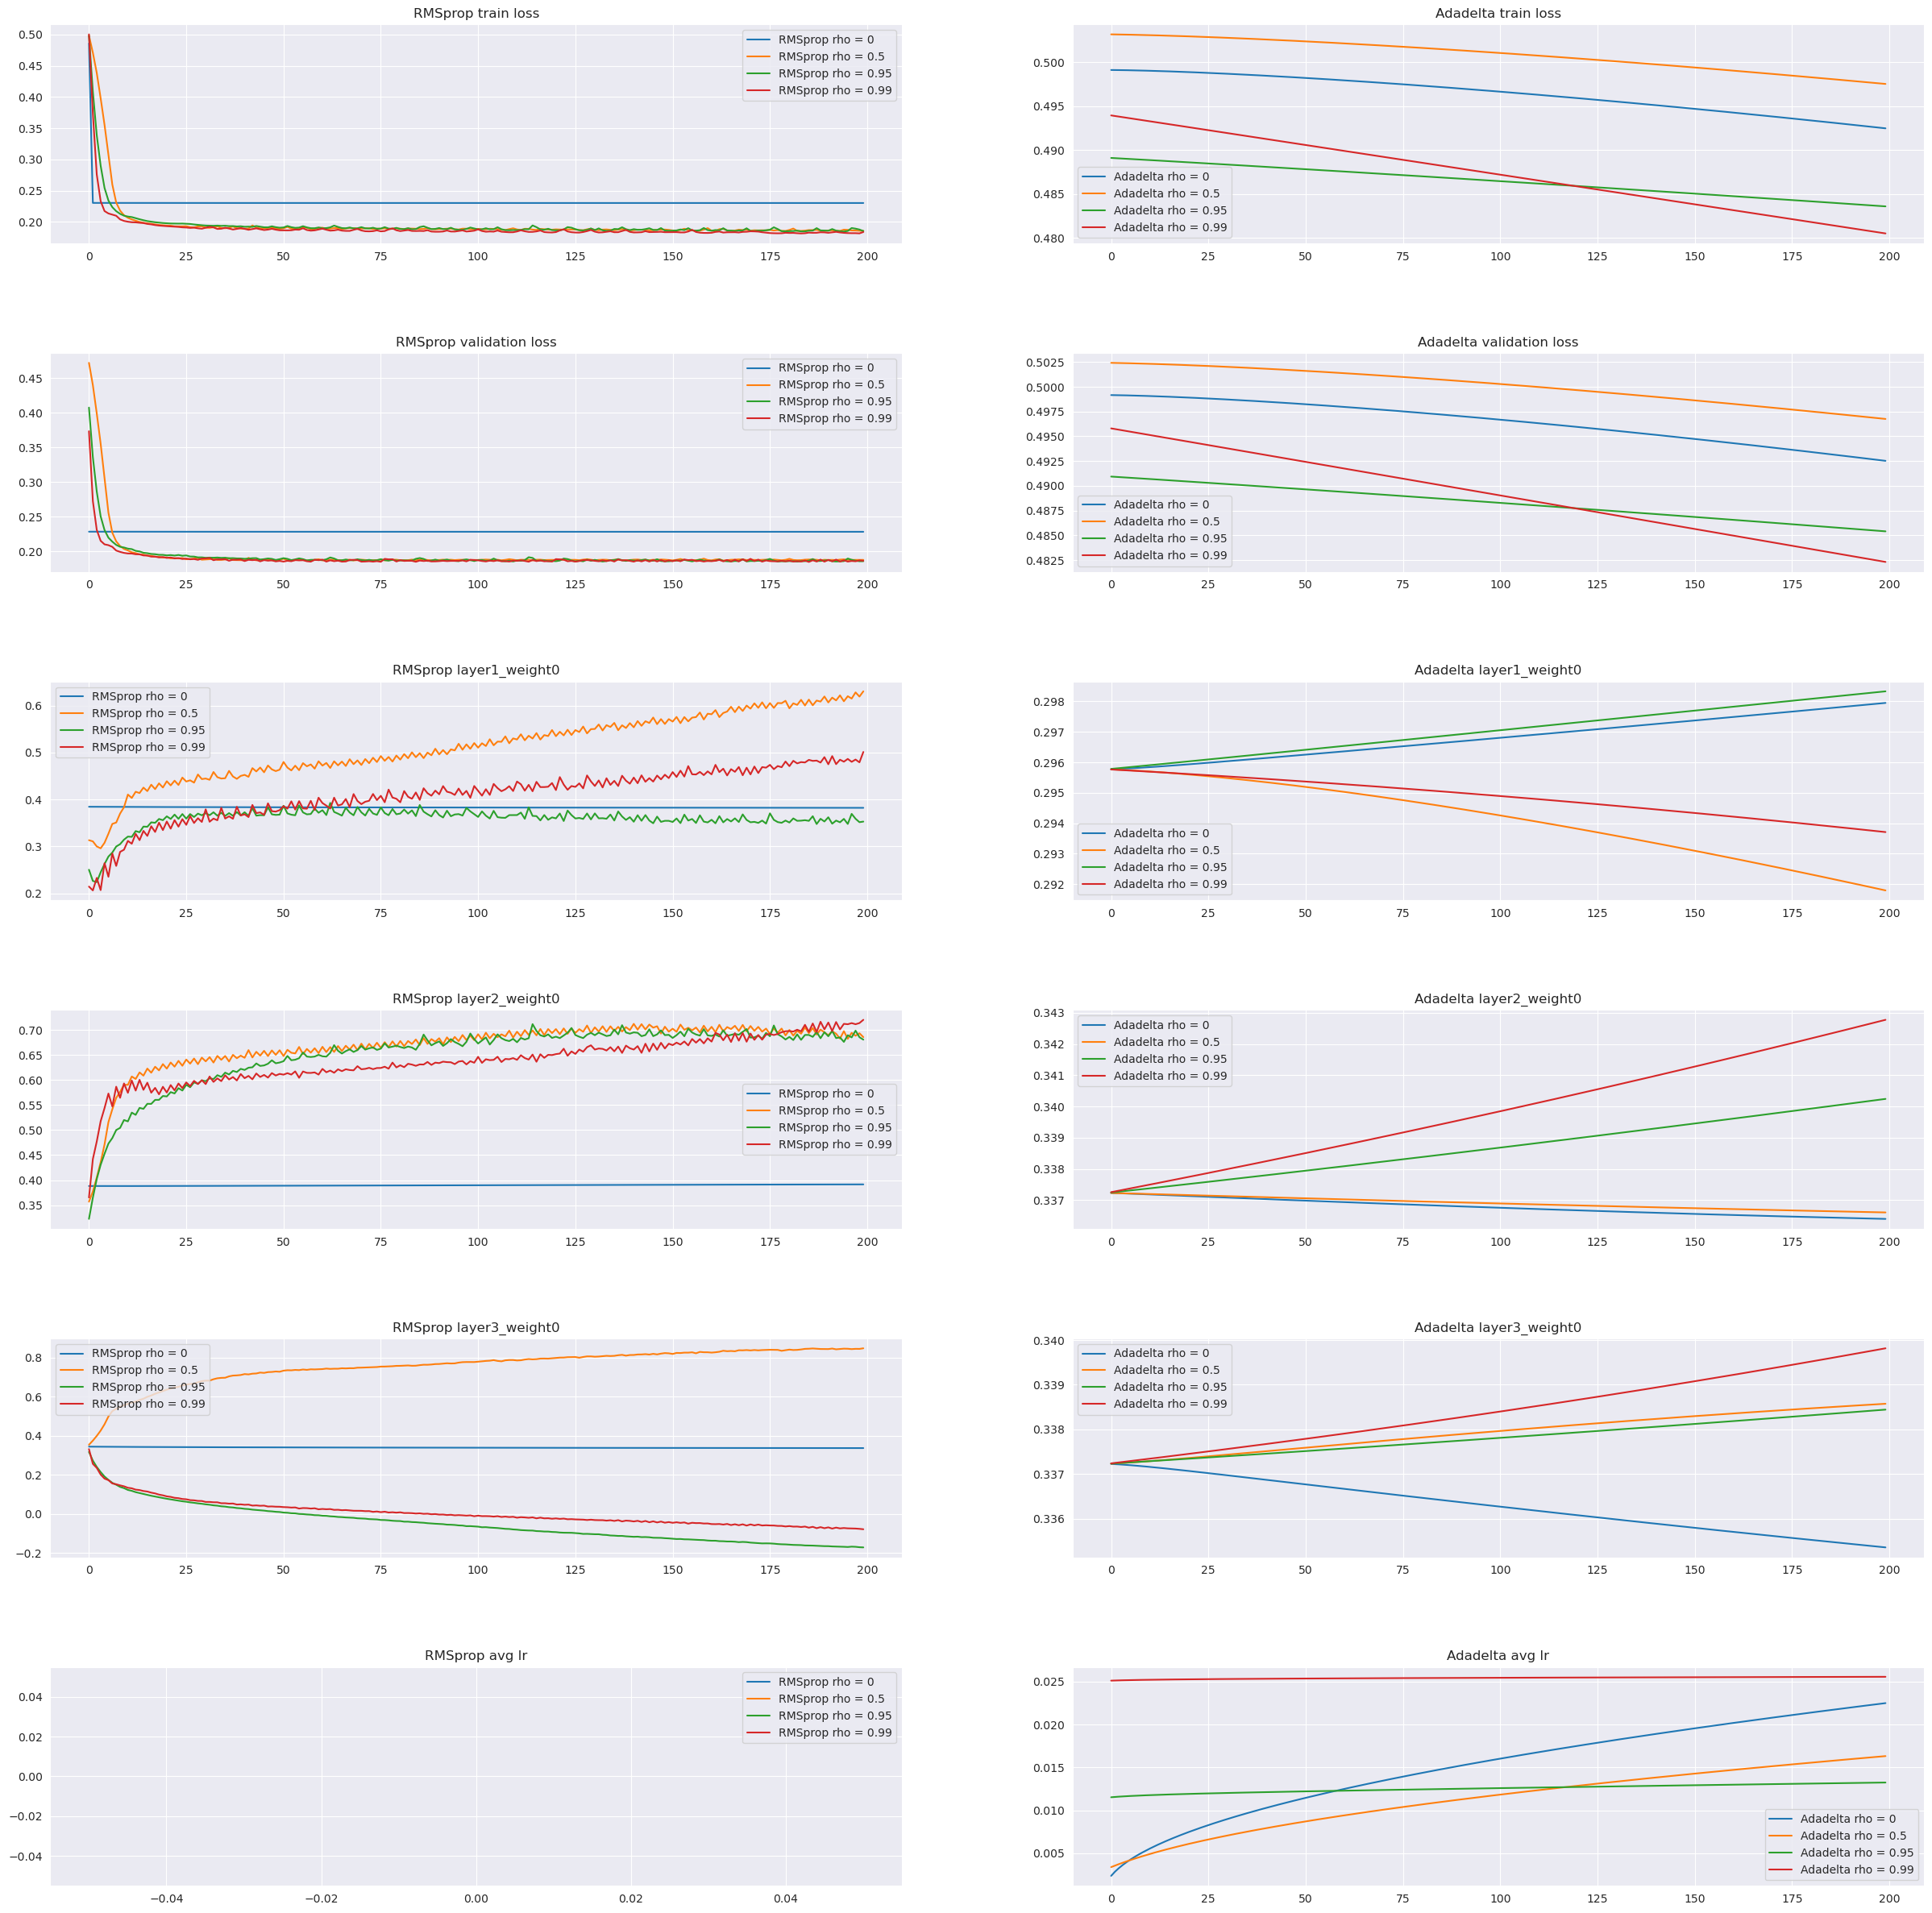

In [22]:
fig, axes = plt.subplots(6, 2, figsize=(30, 30))

for ax, calls, name in zip(axes[0], [rms_callbacks, delta_callbacks], ["RMSprop", "Adadelta"]):
    for rho, call in zip([0, 0.5, 0.95, 0.99], calls):
        sns.lineplot(data=call.history['loss'], 
                             label=f"{name} rho = {rho}",
                         ax=ax)
        ax.set_title(f"{name} train loss")

for ax, calls, name in zip(axes[1], [rms_callbacks, delta_callbacks], ["RMSprop", "Adadelta"]):
    for rho, call in zip([0, 0.5, 0.95, 0.99], calls):
        sns.lineplot(data=call.history['val_loss'], 
                             label=f"{name} rho = {rho}",
                         ax=ax)
        ax.set_title(f"{name} validation loss")
        
for ax, calls, name in zip(axes[2], [rms_callbacks, delta_callbacks], ["RMSprop", "Adadelta"]):
    for rho, call in zip([0, 0.5, 0.95, 0.99], calls):
        sns.lineplot(data=call.history['layer1_weight0'], 
                             label=f"{name} rho = {rho}",
                         ax=ax)
        ax.set_title(f"{name} layer1_weight0")
        
for ax, calls, name in zip(axes[3], [rms_callbacks, delta_callbacks], ["RMSprop", "Adadelta"]):
    for rho, call in zip([0, 0.5, 0.95, 0.99], calls):
        sns.lineplot(data=call.history['layer2_weight0'], 
                             label=f"{name} rho = {rho}",
                         ax=ax)
        ax.set_title(f"{name} layer2_weight0")
        
for ax, calls, name in zip(axes[4], [rms_callbacks, delta_callbacks], ["RMSprop", "Adadelta"]):
    for rho, call in zip([0, 0.5, 0.95, 0.99], calls):
        sns.lineplot(data=call.history['layer3_weight0'], 
                             label=f"{name} rho = {rho}",
                         ax=ax)
        ax.set_title(f"{name} layer3_weight0")
        
for ax, calls, name in zip(axes[5], [rms_callbacks, delta_callbacks], ["RMSprop", "Adadelta"]):
    for rho, call in zip([0, 0.5, 0.95, 0.99], calls):
        sns.lineplot(data=np.cumsum(call.history['lr']) / np.arange(1, len(call.history['lr'])+1), 
                             label=f"{name} rho = {rho}",
                         ax=ax)
        ax.set_title(f"{name} avg lr")
        
plt.subplots_adjust(hspace = 0.5)

### Adam:

In [23]:
initializer = tf.keras.initializers.GlorotNormal(seed=None)
lr = 0.01

In [24]:
def get_Adam_model(learning_rate, betta1, betta2, epochs):
    
    model = Sequential()
    model.add(Dense(10, 
                    input_shape=(n_features,), 
                    activation='tanh', 
                    kernel_initializer=initializer))
    model.add(Dense(10, 
                    activation='tanh',
                    kernel_initializer=initializer))
    model.add(Dense(10, 
                    activation='tanh',
                    kernel_initializer=initializer))
    model.add(Dense(1, activation='sigmoid'))
    
    def get_lr_metric(optimizer):
        def lr(y_true, y_pred):
            return tf.divide(learning_rate, tf.sqrt(optimizer._velocities[-1]))
        return lr

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=betta1, beta_2=betta2)
    lr_metric = get_lr_metric(optimizer)

    model.compile(
        optimizer=optimizer,
        metrics=['accuracy', lr_metric],
        loss='mean_absolute_error', 
        )
    layer1_weight0 = []
    layer2_weight0 = []
    layer3_weight0 = []
    
    layer1_weight0_calls = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda batch, logs: layer1_weight0.append(model.layers[0].get_weights()[0][0][0]))
    layer2_weight0_calls = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda batch, logs: layer2_weight0.append(model.layers[1].get_weights()[0][0][0]))
    layer3_weight0_calls = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda batch, logs: layer3_weight0.append(model.layers[2].get_weights()[0][0][0]))

    callbacks = \
    model.fit(X_train, 
              y_train, 
              epochs = epochs, 
              batch_size = X_train.shape[0],
              validation_data=(X_val, y_val),
              verbose=0,
              callbacks=[layer1_weight0_calls, layer2_weight0_calls, layer3_weight0_calls])
    
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    train_pred_y = model.predict(X_train)
    test_pred_y = model.predict(X_test)
    
    callbacks.history['layer1_weight0'] = layer1_weight0
    callbacks.history['layer2_weight0'] = layer2_weight0
    callbacks.history['layer3_weight0'] = layer3_weight0
    
    return callbacks, bce(y_train, train_pred_y), bce(y_test, test_pred_y)

In [25]:
callbacks = []
train_loss = [] 
test_loss = [] 

betta_list = [[0, 0], [0, 0.5], [0, 0.99], [0.5, 0], [0.5, 0.5], [0.5, 0.99], [0.99, 0], [0.99, 0.5], [0.99, 0.99]]


for betta1, betta2 in betta_list:
        call, train, test = get_Adam_model(learning_rate=lr, betta1=betta1, betta2=betta2, epochs=200)
        callbacks.append(call)
        train_loss.append(train)
        test_loss.append(test)

138/138 [==============================] - 0s 881us/step


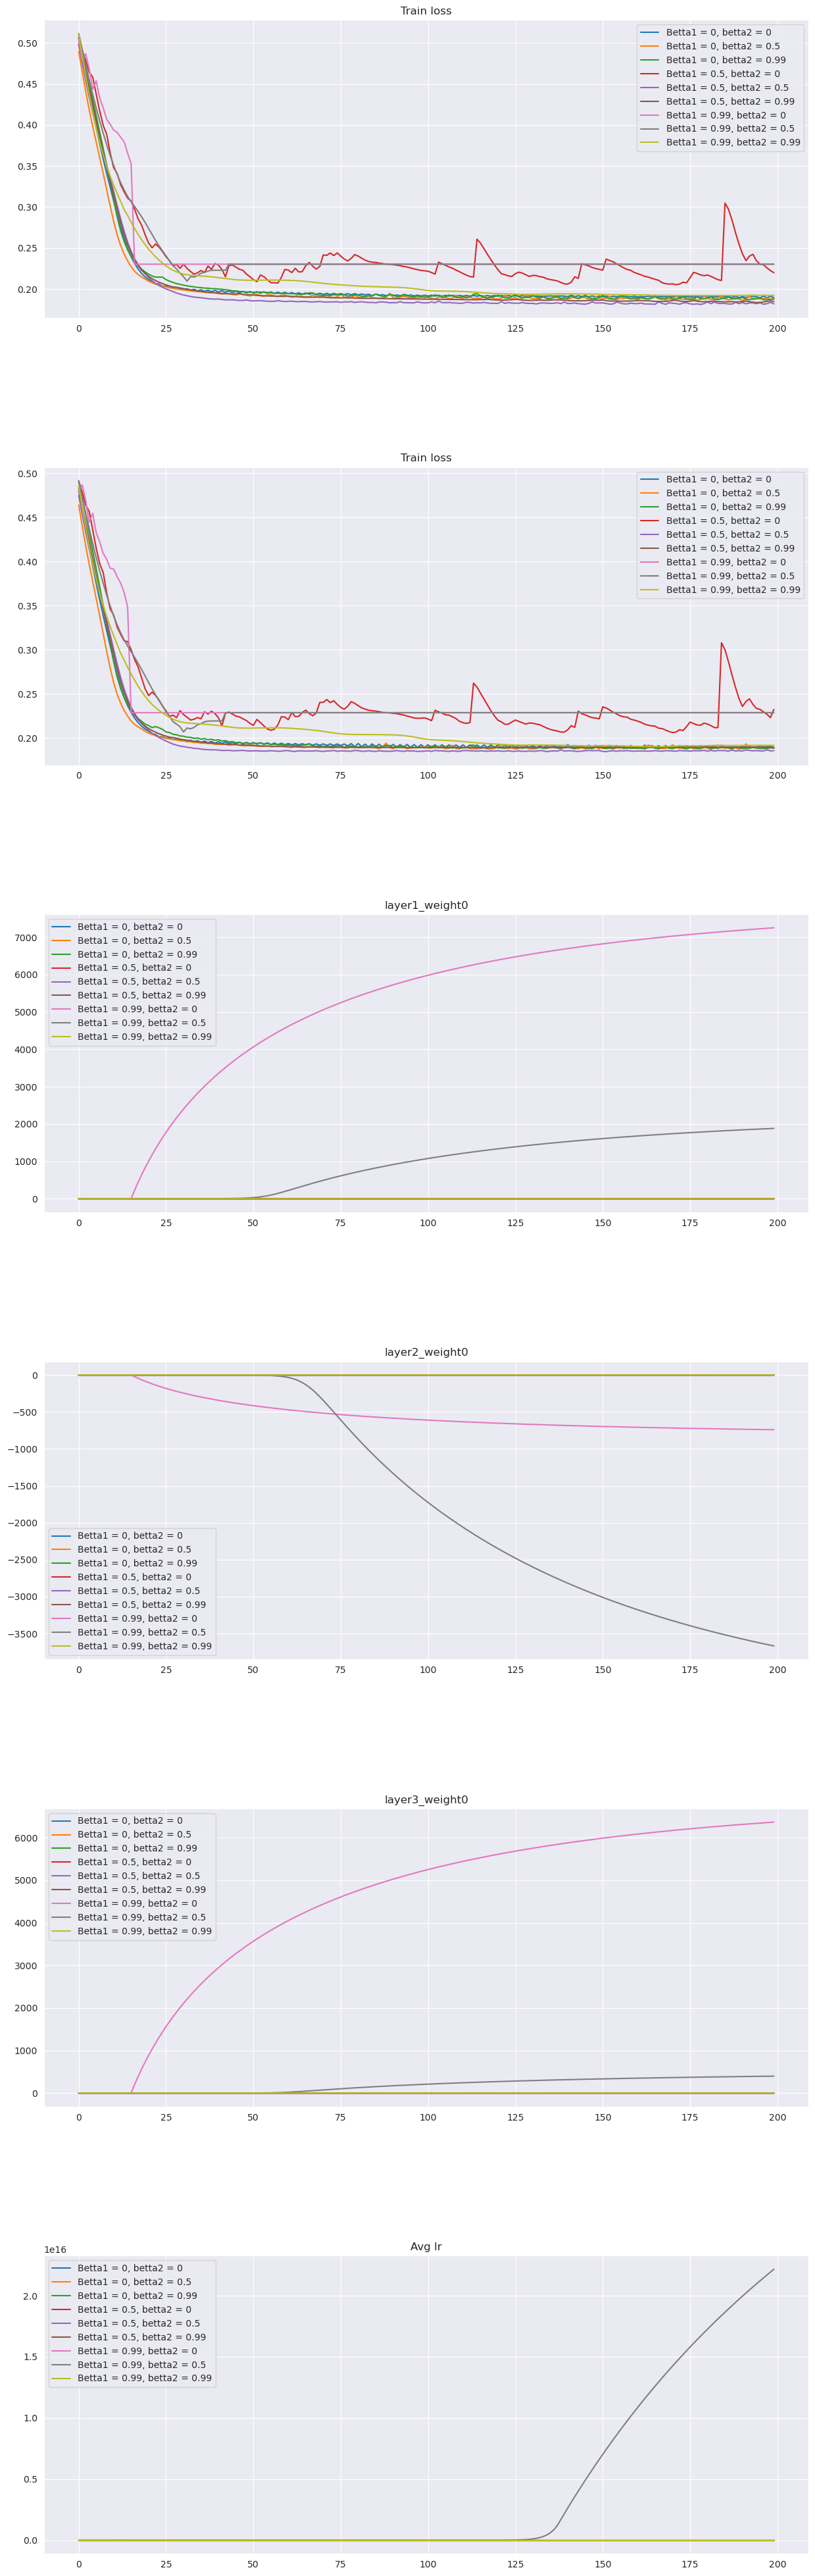

In [26]:
fig, axes = plt.subplots(6, 1, figsize=(15, 50))

for calls, (betta1, betta2) in zip(callbacks, betta_list):
        
        sns.lineplot(data=calls.history['loss'], 
                             label=f"Betta1 = {betta1}, betta2 = {betta2}",
                         ax=axes[0])
        axes[0].set_title(f"Train loss")

for calls, (betta1, betta2) in zip(callbacks, betta_list):
        
        sns.lineplot(data=calls.history['val_loss'], 
                             label=f"Betta1 = {betta1}, betta2 = {betta2}",
                         ax=axes[1])
        axes[1].set_title(f"Train loss")
        
for calls, (betta1, betta2) in zip(callbacks, betta_list):
        
        sns.lineplot(data=calls.history['layer1_weight0'], 
                             label=f"Betta1 = {betta1}, betta2 = {betta2}",
                         ax=axes[2])
        axes[2].set_title(f"layer1_weight0")
        
for calls, (betta1, betta2) in zip(callbacks, betta_list):
        
        sns.lineplot(data=calls.history['layer2_weight0'], 
                             label=f"Betta1 = {betta1}, betta2 = {betta2}",
                         ax=axes[3])
        axes[3].set_title(f"layer2_weight0")
        
for calls, (betta1, betta2) in zip(callbacks, betta_list): 
        sns.lineplot(data=calls.history['layer3_weight0'], 
                             label=f"Betta1 = {betta1}, betta2 = {betta2}",
                         ax=axes[4])
        axes[4].set_title(f"layer3_weight0")
        
for calls, (betta1, betta2) in zip(callbacks, betta_list):
        sns.lineplot(data=np.cumsum(calls.history['lr']) / np.arange(1, len(call.history['lr'])+1), 
                             label=f"Betta1 = {betta1}, betta2 = {betta2}",
                         ax=axes[5])
        axes[5].set_title("Avg lr")
        
plt.subplots_adjust(hspace = 0.5)